# DSCI 592: Capstone Project
# Reel Good Movie Recommender System (Group 4)
- By Alireza Hatami

## 1. Embedding Generation Using LLMs

### 1.1. Loading updated `model_df`

In [ ]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.model_selection import train_test_split

In [25]:
# Load datasets
model_df = pd.read_csv('model_df.csv')
genre_df = pd.read_csv('genre_df.csv') # From DSCI_592_Additional_Preprocessing.ipynb
language_encoded = pd.read_csv('language_encoded.csv') # From DSCI_592_Additional_Preprocessing.ipynb
df = pd.read_csv('cleaned_data.csv')

**Why Use LLM Embeddings?**
- TF-IDF is purely based on word frequency.
- LLM embeddings capture meaning, context, and relationships.
- This is ideal for columns like overview, title, or even a full combined_text.

### 1.2. Embedding Textual Features like Title, Directors, Actors and Overviews of Movies

In [6]:
def embed_and_save(df, column_name, output_prefix, save_dir='./embeddings', model_name='all-mpnet-base-v2'):
    """
    Embeds a column of text using a SentenceTransformer and saves the result.

    Args:
        df (pd.DataFrame): Input dataframe.
        column_name (str): Column to embed.
        output_prefix (str): Filename prefix (e.g., 'title').
        save_dir (str): Directory to save the .npy and model reference.
        model_name (str): Pretrained model name for SentenceTransformer.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"Embedding column: '{column_name}' using {model_name}...")

    model = SentenceTransformer(model_name)
    texts = df[column_name].fillna('').astype(str).tolist()
    embeddings = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)

    # Save the embeddings
    save_path = os.path.join(save_dir, f'{output_prefix}_embeddings2.npy')
    np.save(save_path, embeddings)

    print(f"Saved embeddings to {save_path} | Shape: {embeddings.shape}")

# Embedding the textual features
embed_and_save(model_df, 'title', 'title')
embed_and_save(model_df, 'director_clean', 'director')
embed_and_save(model_df, 'actors_clean', 'actors')
embed_and_save(model_df, 'overview', 'overview')

### 1.3. Stacking for LLM Embeddings

In [12]:
# Load embedding matrices (each shape: [44880, 768] or similar)
title_emb = np.load('./embeddings/title_embeddings.npy')
director_emb = np.load('./embeddings/director_embeddings.npy')
actors_emb = np.load('./embeddings/actors_embeddings.npy')
overview_emb = np.load('./embeddings/overview_embeddings.npy')

# Load one-hot encodings
language_encoded = pd.read_csv('language_encoded.csv').values  # shape: [44880, 11]
genre_df = pd.read_csv('genre_df.csv').values                  # shape: [44880, 30]

# Scaled year (convert to 2D array if needed)
year_scaled = model_df[['year_scaled']].values                 # shape: [44880, 1]

# Stack everything horizontally
final_dense_matrix = np.hstack([
    title_emb,
    director_emb,
    actors_emb,
    overview_emb,
    genre_df,
    language_encoded,
    year_scaled
])

print("Final LLM matrix shape:", final_dense_matrix.shape)

Final LLM matrix shape: (44880, 3114)


### 1.4. Save `final_dense_matrix` to a File:

In [31]:
# # Save as .npy
np.save('final_dense_matrix.npy', final_dense_matrix)

print("final_dense_matrix saved!")

final_dense_matrix saved!


### 1.5. Load `final_dense_matrix`:

In [26]:
# Load from file
final_dense_matrix = np.load('./embeddings/final_dense_matrix.npy')

print("final_dense_matrix loaded!", final_dense_matrix.shape)

final_dense_matrix loaded! (44880, 3114)


### 1.6. Calculating the Similarity Between Movies

In [27]:
def get_similar_movies(title, matrix, model_df, top_n=10):
    """
    Retrieves the top-N most similar movies to the given title based on embedding similarity.

    Args:
        title (str): The title of the query movie.
        matrix (np.ndarray): The embedding matrix where each row corresponds to a movie's vector representation.
        model_df (pd.DataFrame): The DataFrame containing movie metadata 
        top_n (int): The number of most similar movies to return.

    Returns:
        pd.DataFrame: A DataFrame containing the top-N similar movies with metadata and similarity scores.
    """
    # Find the index of the movie in the dataframe
    idx = model_df[model_df['title'] == title].index[0]
    
    # Compute cosine similarity between the query movie and all others
    sim_scores = cosine_similarity(matrix[idx].reshape(1, -1), matrix).flatten()
    # Exclude the movie itself from the results by setting its score very low
    sim_scores[idx] = -1
    
    # Replace lines 23 and 24 with lines 18 and 20 for calculating Euclidean distance
    # sim_scores = -euclidean_distances(matrix[idx].reshape(1, -1), matrix).flatten()
    # sim_scores[idx] = np.min(sim_scores) - 1
    
    # Get indices of top-N highest similarity scores
    top_indices = np.argsort(sim_scores)[-top_n:][::-1]

    # Retrieve metadata for the top-N similar movies
    result_df = model_df.loc[top_indices, [
        'title', 'director_clean', 'actors_clean', 'genres_clean', 'overview', 'original_language'
    ]].copy()

    # Add similarity scores to the result
    result_df['score'] = sim_scores[top_indices]

    # Add the release year from a secondary DataFrame `df`
    result_df['year'] = result_df['title'].apply(
        lambda t: df[df['title'] == t]['year'].values[0] if len(df[df['title'] == t]) > 0 else 'N/A'
    )
    
    return result_df

In [28]:
def print_movie_recommendations(similar_df, max_overview_len=300):
    """
    Pretty prints movie recommendations with director, actors, and a short overview.

    Args:
        similar_df (pd.DataFrame): DataFrame from get_similar_movies().
        max_overview_len (int): Max number of characters to show for overview.
    """   
    for i, row in similar_df.iterrows():
        print(f" {row['title']} ({row['year']}) — Score: {row['score']:.4f}")
        print(f"   Director: {row['director_clean']}")
        print(f"   Actors: {row['actors_clean']}")
        print(f"   Genres: {row['genres_clean']}")
        print(f"   Overview: {row['overview'][:max_overview_len]}...\n")
        print("-"*60)

In [29]:
print_movie_recommendations(get_similar_movies('Toy Story', final_dense_matrix, model_df, top_n=10))

 Toy Story 2 (1999) — Score: 0.9526
   Director: John_Lasseter
   Actors: Tom_Hanks Tim_Allen Joan_Cusack
   Genres: ['Animation', 'Comedy', 'Family']
   Overview: Andy heads off to Cowboy Camp, leaving his toys to their own devices. Things shift into high gear when an obsessive toy collector named Al McWhiggen, owner of Al's Toy Barn kidnaps Woody. Andy's toys mount a daring rescue mission, Buzz Lightyear meets his match and Woody has to decide where he and h...

------------------------------------------------------------
 Toy Story 3 (2010) — Score: 0.8856
   Director: Lee_Unkrich
   Actors: Tom_Hanks Tim_Allen Ned_Beatty
   Genres: ['Animation', 'Family', 'Comedy']
   Overview: Woody, Buzz, and the rest of Andy's toys haven't been played with in years. With Andy about to go to college, the gang find themselves accidentally left at a nefarious day care center. The toys must band together to escape and return home to Andy....

---------------------------------------------------------

In [30]:
print_movie_recommendations(get_similar_movies('The Matrix', final_dense_matrix, model_df, top_n=10))

 The Matrix Revolutions (2003) — Score: 0.8200
   Director: Lilly_Wachowski
   Actors: Keanu_Reeves Laurence_Fishburne Carrie-Anne_Moss
   Genres: ['Adventure', 'Action', 'Thriller', 'Science', 'Fiction']
   Overview: The human city of Zion defends itself against the massive invasion of the machines as Neo fights to end the war at another front while also opposing the rogue Agent Smith....

------------------------------------------------------------
 The Matrix Reloaded (2003) — Score: 0.8137
   Director: Lilly_Wachowski
   Actors: Keanu_Reeves Carrie-Anne_Moss Laurence_Fishburne
   Genres: ['Adventure', 'Action', 'Thriller', 'Science', 'Fiction']
   Overview: Six months after the events depicted in The Matrix, Neo has proved to be a good omen for the free humans, as more and more humans are being freed from the matrix and brought to Zion, the one and only stronghold of the Resistance.  Neo himself has discovered his superpowers including super speed, abi...

-------------------------

### 1.7. Performance Evaluation

The most relevant and feasible metrics for our current setup are:

**1. Precision@K**
- Measures how many of the top-K recommended movies are actually relevant.

**2. Recall@K**
- Measures how many of the truly relevant movies were found among the top K results.

- Recall is useful if we think missing good recommendations is worse than showing a few less perfect ones.

**Note:**
- To determine the relevance of recommendations in a dataset of 45,000 movies, relying solely on "same genre" can result in an artificially low recall. This is due to the large number of genre matches present across the dataset.

**3. Mean Reciprocal Rank (MRR)**
- Looks at the rank position of the first relevant recommendation.
​
 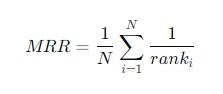
- Higher is better. If a relevant movie appears in the first position, MRR = 1

#### 1.7.1. `is_relevant()` Function

In [12]:
def is_relevant(query_row, candidate_row):
    """
    Determines whether a candidate movie is relevant to a query movie
    based on metadata attributes such as language, director, genres, and actors.

    Relevance Criteria (evaluated in order):
        1. The original language must match.
        2. The director is the same.
        3. At least two genres overlap.
        4. At least one actor is the same.

    Args:
        query_row (pd.Series): The row representing the query movie.
        candidate_row (pd.Series): The row representing a potential similar movie.

    Returns:
        bool: True if the candidate movie is relevant to the query movie, False otherwise.
    """
    
    # 1. Language must match
    if query_row['original_language'] != candidate_row['original_language']:
        return False

    # 2. Director match
    if query_row['director_clean'] == candidate_row['director_clean']:
        return True

    # 3. At least 2 genres match
    query_genres = set(eval(query_row['genres_clean']))
    candidate_genres = set(eval(candidate_row['genres_clean']))
    if len(query_genres.intersection(candidate_genres)) >= 2:
        return True

    # 4. At least 1 actor match
    query_actors = set(query_row['actors_clean'].split())
    candidate_actors = set(candidate_row['actors_clean'].split())
    if len(query_actors.intersection(candidate_actors)) >= 1:
        return True

    # None matched
    return False

#### 1.7.2. `Precision@K` Function

How many of the top-K recommended movies are actually relevant?

In [13]:
def precision_at_k(query_title, model_df, matrix, k=10):
    """
    Calculates Precision@K for a given movie based on metadata similarity.

    Precision@K is defined as the proportion of recommended items in the top K
    that are relevant to the query item.

    Args:
        query_title (str): The title of the query movie.
        model_df (pd.DataFrame): The DataFrame containing movie metadata.
        matrix (np.ndarray or sparse matrix): The embedding or similarity matrix used for recommendations.
        k (int): The number of top recommendations to consider (default is 10).

    Returns:
        float: Precision@K score (between 0 and 1).
    """
    
    idx = model_df[model_df['title'] == query_title].index[0]
    query_row = model_df.iloc[idx]

    # Get top-K recommended movies
    recommended = get_similar_movies(query_title, matrix, model_df, top_n=k)

    # Count how many of the top-K are relevant
    relevant_count = 0
    for _, candidate_row in recommended.iterrows():
        if is_relevant(query_row, candidate_row):
            relevant_count += 1

    # Precision = relevant retrieved items / total retrieved items (k)
    precision = relevant_count / k
    
    return precision

#### 1.7.3. `Recall@K` Function

Out of all relevant movies in the full catalog, how many were retrieved in top K?

Recall needs to know:

- Total number of relevant movies across all 45,000.

- Among those, how many did we retrieve.

In [14]:
def recall_at_k(query_title, model_df, matrix, k=10):
    """
    Calculates Recall@K for a given movie based on metadata similarity.

    Recall@K is defined as the proportion of all relevant items that are 
    retrieved in the top K recommendations.

    Args:
        query_title (str): The title of the query movie.
        model_df (pd.DataFrame): The DataFrame containing movie metadata.
        matrix (np.ndarray or sparse matrix): The embedding or similarity matrix used for recommendations.
        k (int): The number of top recommendations to consider (default is 10).

    Returns:
        float: Recall@K score (between 0 and 1). Returns 0.0 if there are no relevant items.
    """
    
    idx = model_df[model_df['title'] == query_title].index[0]
    query_row = model_df.iloc[idx]

    # Find all relevant movies in dataset
    relevant_total = 0
    for _, candidate_row in model_df.iterrows():
        if is_relevant(query_row, candidate_row):
            relevant_total += 1

    # Prevent division by zero
    if relevant_total == 0:
        return 0.0

    # Get top-k recommended
    recommended = get_similar_movies(query_title, matrix, model_df, top_n=k)

    relevant_in_topk = 0
    for _, candidate_row in recommended.iterrows():
        if is_relevant(query_row, candidate_row):
            relevant_in_topk += 1

    recall = relevant_in_topk / relevant_total
    return recall

#### 1.7.4. `MRR@K (Mean Reciprocal Rank)`

At what rank does the first relevant movie appear? Earlier is better

- "How early did I show the user something they liked?"
- If our system shows a good result early ➔ MRR is high
- If a user has to scroll a lot to find good stuff ➔ MRR is low

In [15]:
def mrr_at_k(query_title, model_df, matrix, k=10):
    """
    Computes the Mean Reciprocal Rank (MRR@K) for a given query movie.

    MRR@K measures how early the first relevant recommendation appears in 
    the top-K results. If no relevant movie is found in the top-K, the score is 0.

    Args:
        query_title (str): The title of the query movie.
        model_df (pd.DataFrame): The DataFrame containing movie metadata.
        matrix (np.ndarray or sparse matrix): The embedding or similarity matrix used for recommendations.
        k (int): Number of top recommendations to consider (default is 10).

    Returns:
        float: MRR@K score (1/rank of the first relevant item, or 0.0 if none found).
    """
    
    idx = model_df[model_df['title'] == query_title].index[0]
    query_row = model_df.iloc[idx]

    recommended = get_similar_movies(query_title, matrix, model_df, top_n=k)

    for rank, (_, candidate_row) in enumerate(recommended.iterrows(), start=1):
        if is_relevant(query_row, candidate_row):
            return 1 / rank  # Reciprocal Rank

    return 0.0  # No relevant item found

#### 1.7.5. `evaluate_multiple_queries()`

In [16]:
def evaluate_multiple_queries(model_df, matrix, num_samples=100, k=10, seed=42):
    """
    Evaluates recommendation quality across multiple random query movies using Precision@K, Recall@K, and MRR@K.

    Args:
        model_df (pd.DataFrame): The DataFrame containing metadata for all movies.
        matrix (np.ndarray or sparse matrix): The embedding or similarity matrix for recommendations.
        num_samples (int): Number of random movies to evaluate.
        k (int): Number of top recommendations to consider for each metric (default is 10).
        seed (int): Random seed for reproducibility (default is 42).

    Returns:
        tuple: Mean Precision@K, Recall@K, and MRR@K scores across the sampled queries.
    """
    
    random.seed(seed)  # for reproducibility

    # Randomly pick num_samples titles
    sample_titles = random.sample(list(model_df['title']), num_samples)

    precisions = []
    recalls = []
    mrrs = []

    for title in sample_titles:
        try:
            # Compute evaluation metrics for each sampled movie
            precision = precision_at_k(title, model_df, matrix, k)
            recall = recall_at_k(title, model_df, matrix, k)
            mrr = mrr_at_k(title, model_df, matrix, k)

            precisions.append(precision)
            recalls.append(recall)
            mrrs.append(mrr)
        
        except Exception as e:
            print(f"Skipping '{title}' due to error: {e}")
            continue

    # Calculate mean metrics across all successful queries
    mean_precision = sum(precisions) / len(precisions) if precisions else 0
    mean_recall = sum(recalls) / len(recalls) if recalls else 0
    mean_mrr = sum(mrrs) / len(mrrs) if mrrs else 0

    print(f"\nEvaluation Results over {len(precisions)} movies:")
    print(f"➡Mean Precision@{k}: {mean_precision:.4f}")
    print(f"➡Mean Recall@{k}: {mean_recall:.4f}")
    print(f"➡Mean MRR@{k}: {mean_mrr:.4f}")

    return mean_precision, mean_recall, mean_mrr

#### 1.7.6. Evaluatation `@5`, `@10` and `@20` Using Cosine Similarity

In [17]:
# Evaluate on 100 random movies, top-5 recommendations
mean_precision, mean_recall, mean_mrr = evaluate_multiple_queries(model_df, final_dense_matrix, num_samples=100, k=5)


Evaluation Results over 100 movies:
➡Mean Precision@5: 0.7000
➡Mean Recall@5: 0.0311
➡Mean MRR@5: 0.7470


In [21]:
# Evaluate on 100 random movies, top-10 recommendations
mean_precision, mean_recall, mean_mrr = evaluate_multiple_queries(model_df, final_dense_matrix, num_samples=100, k=10)


Evaluation Results over 100 movies:
➡Mean Precision@10: 0.6820
➡Mean Recall@10: 0.0459
➡Mean MRR@10: 0.7505


In [18]:
# Evaluate on 100 random movies, top-20 recommendations
mean_precision, mean_recall, mean_mrr = evaluate_multiple_queries(model_df, final_dense_matrix, num_samples=100, k=20)


Evaluation Results over 100 movies:
➡Mean Precision@20: 0.6745
➡Mean Recall@20: 0.0708
➡Mean MRR@20: 0.7538


 So, MRR tends to increase (or stay the same) as K increases,
because we're expanding the window and may capture relevant items earlier in that larger range.

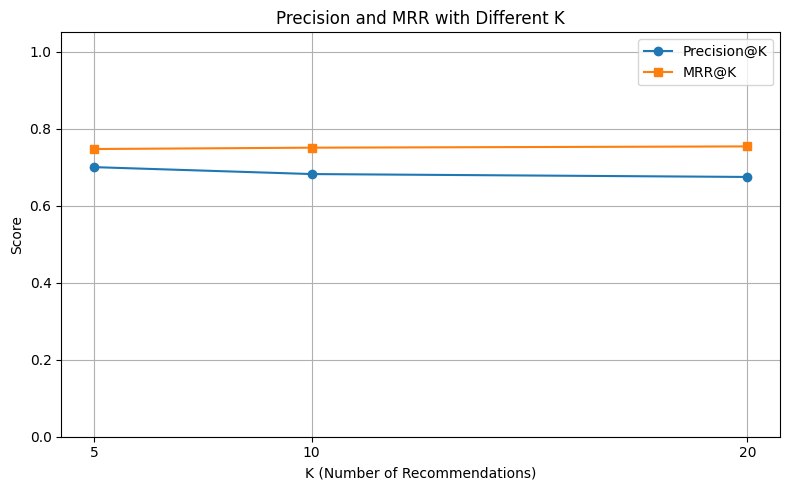

In [31]:
# Example values — replace these with your real results
k_values = [5, 10, 20]
precision_values = [0.7000, 0.6820, 0.6745]  # from your evaluation
mrr_values = [0.7470, 0.7505, 0.7538]

# Create the plot
plt.figure(figsize=(8, 5))

# Plot Precision
plt.plot(k_values, precision_values, marker='o', label='Precision@K')

# Plot MRR
plt.plot(k_values, mrr_values, marker='s', label='MRR@K')

# Customize the plot
plt.title('Precision and MRR with Different K')
plt.xlabel('K (Number of Recommendations)')
plt.ylabel('Score')
plt.xticks(k_values)
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

#### 1.7.7. Exploring Euclidean Distance as a Similarity Metric

In [39]:
# Evaluate on 100 random movies, top-5 recommendations
mean_precision, mean_recall, mean_mrr = evaluate_multiple_queries(model_df, final_dense_matrix, num_samples=100, k=5, seed=1)


Evaluation Results over 100 movies:
➡Mean Precision@5: 0.7060
➡Mean Recall@5: 0.0366
➡Mean MRR@5: 0.7853


In [17]:
# Evaluate on 100 random movies, top-5 recommendations
mean_precision, mean_recall, mean_mrr = evaluate_multiple_queries(model_df, final_dense_matrix, num_samples=100, k=5)


Evaluation Results over 100 movies:
➡Mean Precision@5: 0.7040
➡Mean Recall@5: 0.0299
➡Mean MRR@5: 0.7545


In [18]:
# Evaluate on 100 random movies, top-10 recommendations
mean_precision, mean_recall, mean_mrr = evaluate_multiple_queries(model_df, final_dense_matrix, num_samples=100, k=10)


Evaluation Results over 100 movies:
➡Mean Precision@10: 0.6910
➡Mean Recall@10: 0.0496
➡Mean MRR@10: 0.7593


In [19]:
# Evaluate on 100 random movies, top-20 recommendations
mean_precision, mean_recall, mean_mrr = evaluate_multiple_queries(model_df, final_dense_matrix, num_samples=100, k=20)


Evaluation Results over 100 movies:
➡Mean Precision@20: 0.6720
➡Mean Recall@20: 0.0695
➡Mean MRR@20: 0.7606


In [20]:
# Summary of the Results
k_values = [5, 10, 20]

cosine_metrics = {
    'P': [0.7000, 0.6820, 0.6745],
    'R': [0.0311, 0.0459, 0.0708],
    'MRR': [0.7470, 0.7505, 0.7538]
}


euclidean_metrics = {
    'P': [0.7040, 0.6910, 0.6720],
    'R': [0.0299, 0.0496, 0.0695],
    'MRR': [0.7545, 0.7593, 0.7606]}

In [21]:
def plot_comparison(cosine_metrics, euclidean_metrics, k_values):
    """
    Plots a side-by-side comparison of evaluation metrics (Precision@K, Recall@K, MRR@K)
    between Cosine and Euclidean similarity measures over different values of K.

    Args:
        cosine_metrics (dict): Dictionary containing 'P', 'R', and 'MRR' lists for Cosine similarity.
        euclidean_metrics (dict): Dictionary containing 'P', 'R', and 'MRR' lists for Euclidean distance.
        k_values (list): List of K values corresponding to each metric score.
    """
    
    metrics = ['P', 'R', 'MRR']
    labels = ['Precision@K', 'Recall@K', 'MRR@K']
    
    plt.figure(figsize=(12, 5))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i + 1)
        plt.plot(k_values, cosine_metrics[metric], marker='o', label='Cosine')
        plt.plot(k_values, euclidean_metrics[metric], marker='s', label='Euclidean')
        plt.title(labels[i])
        plt.xlabel('K')
        plt.ylabel('Score')
        plt.xticks(k_values)
        plt.ylim(0, 1.05)
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

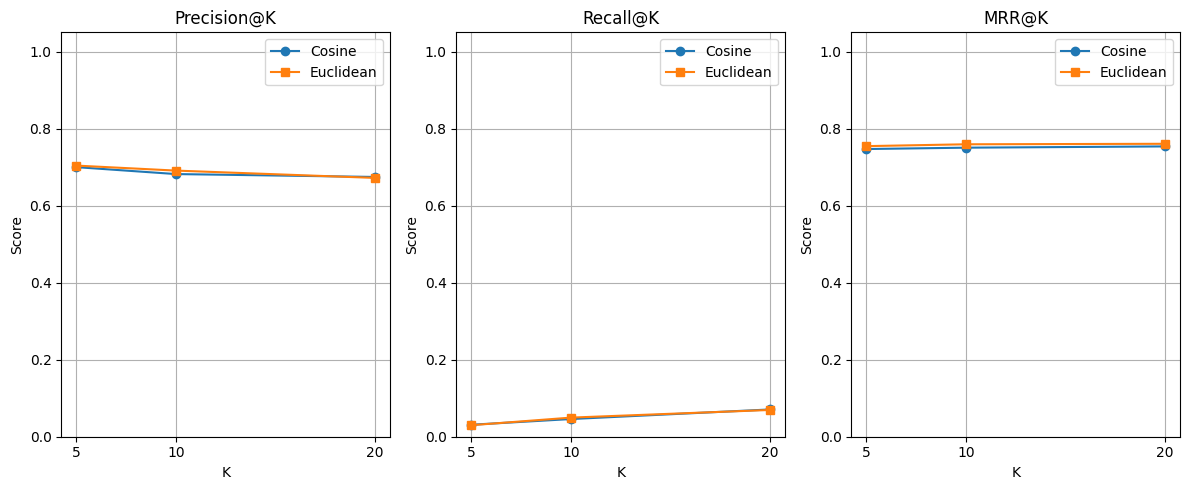

In [22]:
plot_comparison(cosine_metrics, euclidean_metrics, k_values)

------------------------------

## 2. Embedding Generation Using `all-MiniLM-L6-v2` 

### 2.1. Embedding Textual Features like Title, Directors, Actors and Overviews of Movies

In [40]:
def embed_and_save_small(df, column_name, output_prefix, save_dir='./embeddings', model_name='all-MiniLM-L6-v2'):
    """
    Embeds a column of text using a SentenceTransformer and saves the result.

    Args:
        df (pd.DataFrame): Input dataframe.
        column_name (str): Column to embed.
        output_prefix (str): Filename prefix (e.g., 'title').
        save_dir (str): Directory to save the .npy and model reference.
        model_name (str): Pretrained model name for SentenceTransformer.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"Embedding column: '{column_name}' using {model_name}...")

    model = SentenceTransformer(model_name)
    texts = df[column_name].fillna('').astype(str).tolist()
    embeddings = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)

    # Save the embeddings
    save_path = os.path.join(save_dir, f'{output_prefix}_embeddings_small.npy')
    np.save(save_path, embeddings)

    print(f"Saved embeddings to {save_path} | Shape: {embeddings.shape}")

# Embedding the textual features
embed_and_save(model_df, 'title', 'title')
embed_and_save(model_df, 'director_clean', 'director')
embed_and_save(model_df, 'actors_clean', 'actors')
embed_and_save(model_df, 'overview', 'overview')

We can load the results (if created before), and stack everything horizontally:

In [45]:
# Load embedding matrices (each shape: [44880, 768] or similar)
title_emb_small = np.load('./embeddings/title_embeddings_small.npy')
director_emb_small = np.load('./embeddings/director_embeddings_small.npy')
actors_emb_small = np.load('./embeddings/actors_embeddings_small.npy')
overview_emb_small = np.load('./embeddings/overview_embeddings_small.npy')

# Load one-hot encodings
language_encoded = pd.read_csv('language_encoded.csv').values  # shape: [44880, 11]
genre_df = pd.read_csv('genre_df.csv').values                  # shape: [44880, 30]

# Scaled year (convert to 2D array if needed)
year_scaled = model_df[['year_scaled']].values                 # shape: [44880, 1]

# Stack everything horizontally
final_dense_matrix_small = np.hstack([
    title_emb_small,
    director_emb_small,
    actors_emb_small,
    overview_emb_small,
    genre_df,
    language_encoded,
    year_scaled
])

print("Final LLM matrix shape:", final_dense_matrix_small.shape)

Final LLM matrix shape: (44880, 1578)


In [46]:
# # import numpy as np

# # Save as .npy
# np.save('./embeddings/final_dense_matrix_small.npy', final_dense_matrix_small)

# print("final_dense_matrix_small saved!")

final_dense_matrix_small saved!


### 2.2. Load `final_dense_matrix_small`:

In [31]:
# import numpy as np

# Load from file
final_dense_matrix_small = np.load('./embeddings/final_dense_matrix_small.npy')

print("final_dense_matrix_small loaded!", final_dense_matrix_small.shape)

final_dense_matrix_small loaded! (44880, 1578)


### 2.3. Calculating the Similarities

In [35]:
def get_similar_movies(title, matrix, model_df, top_n=10):
    """
    Retrieves the top-N most similar movies to a given title based on a similarity matrix.

    Args:
        title (str): The title of the query movie.
        matrix (np.ndarray): Dense matrix containing embeddings for all movies.
        model_df (pd.DataFrame): DataFrame containing metadata for the movies, including 'title'.
        top_n (int): Number of similar movies to return.

    Returns:
        pd.DataFrame: A DataFrame of the top-N similar movies with metadata and similarity scores.
    """
    
    idx = model_df[model_df['title'] == title].index[0]
    sim_scores = cosine_similarity(matrix[idx].reshape(1, -1), matrix).flatten()
    sim_scores[idx] = -1 
    # sim_scores = -euclidean_distances(matrix[idx].reshape(1, -1), matrix).flatten() # why -? Euclidean Distance = lower means more similar
    # sim_scores[idx] = np.min(sim_scores) - 1
    top_indices = np.argsort(sim_scores)[-top_n:][::-1]

    result_df = model_df.loc[top_indices, [
        'title', 'director_clean', 'actors_clean', 'genres_clean', 'overview', 'original_language'
    ]].copy()
    result_df['score'] = sim_scores[top_indices]

    result_df['year'] = result_df['title'].apply(
        lambda t: df[df['title'] == t]['year'].values[0] if len(df[df['title'] == t]) > 0 else 'N/A'
    )
    
    return result_df

In [36]:
def print_movie_recommendations(similar_df, max_overview_len=300):
    """
    Pretty prints movie recommendations with director, actors, and a short overview.

    Args:
        similar_df (pd.DataFrame): DataFrame from get_similar_movies().
        max_overview_len (int): Max number of characters to show for overview.
    """   
    for i, row in similar_df.iterrows():
        print(f" {row['title']} ({row['year']}) — Score: {row['score']:.4f}")
        print(f"   Director: {row['director_clean']}")
        print(f"   Actors: {row['actors_clean']}")
        print(f"   Genres: {row['genres_clean']}")
        print(f"   Overview: {row['overview'][:max_overview_len]}...\n")
        print("-"*60)

In [37]:
print_movie_recommendations(get_similar_movies('Toy Story', final_dense_matrix_small, model_df, top_n=10))

 Toy Story 2 (1999) — Score: 0.9329
   Director: John_Lasseter
   Actors: Tom_Hanks Tim_Allen Joan_Cusack
   Genres: ['Animation', 'Comedy', 'Family']
   Overview: Andy heads off to Cowboy Camp, leaving his toys to their own devices. Things shift into high gear when an obsessive toy collector named Al McWhiggen, owner of Al's Toy Barn kidnaps Woody. Andy's toys mount a daring rescue mission, Buzz Lightyear meets his match and Woody has to decide where he and h...

------------------------------------------------------------
 Toy Story 3 (2010) — Score: 0.8506
   Director: Lee_Unkrich
   Actors: Tom_Hanks Tim_Allen Ned_Beatty
   Genres: ['Animation', 'Family', 'Comedy']
   Overview: Woody, Buzz, and the rest of Andy's toys haven't been played with in years. With Andy about to go to college, the gang find themselves accidentally left at a nefarious day care center. The toys must band together to escape and return home to Andy....

---------------------------------------------------------

In [38]:
print_movie_recommendations(get_similar_movies('The Matrix', final_dense_matrix_small, model_df, top_n=10))

 The Matrix Reloaded (2003) — Score: 0.7963
   Director: Lilly_Wachowski
   Actors: Keanu_Reeves Carrie-Anne_Moss Laurence_Fishburne
   Genres: ['Adventure', 'Action', 'Thriller', 'Science', 'Fiction']
   Overview: Six months after the events depicted in The Matrix, Neo has proved to be a good omen for the free humans, as more and more humans are being freed from the matrix and brought to Zion, the one and only stronghold of the Resistance.  Neo himself has discovered his superpowers including super speed, abi...

------------------------------------------------------------
 The Matrix Revolutions (2003) — Score: 0.7904
   Director: Lilly_Wachowski
   Actors: Keanu_Reeves Laurence_Fishburne Carrie-Anne_Moss
   Genres: ['Adventure', 'Action', 'Thriller', 'Science', 'Fiction']
   Overview: The human city of Zion defends itself against the massive invasion of the machines as Neo fights to end the war at another front while also opposing the rogue Agent Smith....

-------------------------

#### 2.3.1 Evaluating the MiniML Model for `@5`, `@10` and `@20` Using Cosine Similarity

In [32]:
# Evaluate on 100 random movies, top-5 recommendations
mean_precision, mean_recall, mean_mrr = evaluate_multiple_queries(model_df, final_dense_matrix_small, num_samples=100, k=5)


Evaluation Results over 100 movies:
➡Mean Precision@5: 0.7140
➡Mean Recall@5: 0.0416
➡Mean MRR@5: 0.7760


In [27]:
# Evaluate on 100 random movies, top-10 recommendations
mean_precision, mean_recall, mean_mrr = evaluate_multiple_queries(model_df, final_dense_matrix_small, num_samples=100, k=10)


Evaluation Results over 100 movies:
➡Mean Precision@10: 0.6930
➡Mean Recall@10: 0.0528
➡Mean MRR@10: 0.7793


In [33]:
# Evaluate on 100 random movies, top-20 recommendations
mean_precision, mean_recall, mean_mrr = evaluate_multiple_queries(model_df, final_dense_matrix_small, num_samples=100, k=20)


Evaluation Results over 100 movies:
➡Mean Precision@20: 0.6775
➡Mean Recall@20: 0.0733
➡Mean MRR@20: 0.7798


#### 2.3.2 Exploring Euclidean Distance as a Similarity Metric

In [27]:
# Evaluate on 100 random movies, top-5 recommendations
mean_precision, mean_recall, mean_mrr = evaluate_multiple_queries(model_df, final_dense_matrix_small, num_samples=100, k=5)


Evaluation Results over 100 movies:
➡Mean Precision@5: 0.7180
➡Mean Recall@5: 0.0421
➡Mean MRR@5: 0.7715


In [28]:
# Evaluate on 100 random movies, top-10 recommendations
mean_precision, mean_recall, mean_mrr = evaluate_multiple_queries(model_df, final_dense_matrix_small, num_samples=100, k=10)


Evaluation Results over 100 movies:
➡Mean Precision@10: 0.6930
➡Mean Recall@10: 0.0531
➡Mean MRR@10: 0.7715


In [29]:
# Evaluate on 100 random movies, top-20 recommendations
mean_precision, mean_recall, mean_mrr = evaluate_multiple_queries(model_df, final_dense_matrix_small, num_samples=100, k=20)


Evaluation Results over 100 movies:
➡Mean Precision@20: 0.6710
➡Mean Recall@20: 0.0736
➡Mean MRR@20: 0.7736


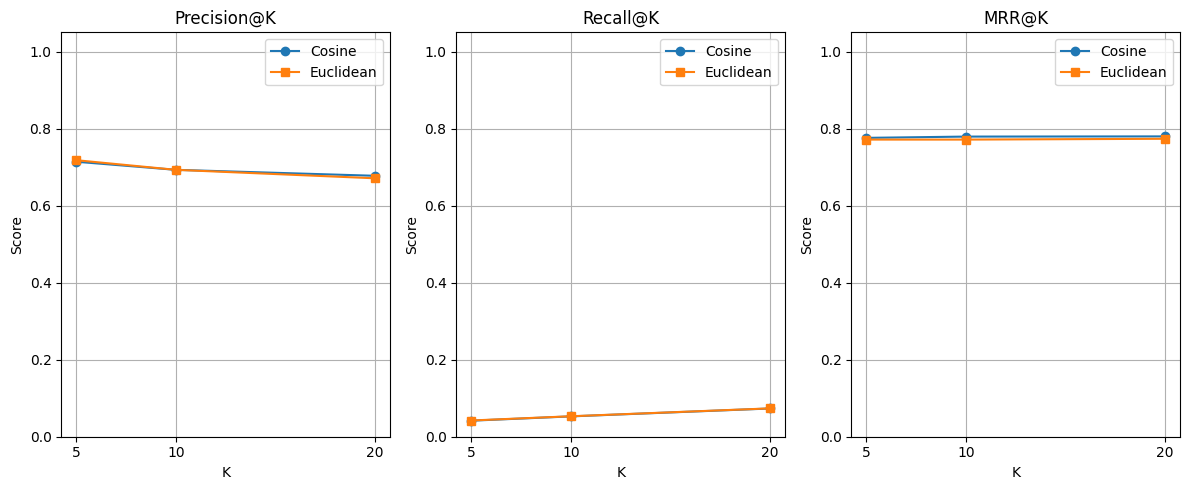

In [42]:
# Summary of the results
cosine_metrics_minilm = {
    'P': [0.7140, 0.6930, 0.6775],
    'R': [0.0416, 0.0528, 0.0733],
    'MRR': [0.7760, 0.7793, 0.7798]
}

euclidean_metrics_minilm = {
    'P': [0.7180, 0.6930, 0.6710],
    'R': [0.0421, 0.0531, 0.0736],
    'MRR': [0.7715, 0.7715, 0.7736]
}

# Then reuse your existing function
plot_comparison(cosine_metrics_minilm, euclidean_metrics_minilm, k_values=[5, 10, 20]) # The function is defined in previous sections (1.7.7.)

Since we have 45000 movies, it will take a lot of computational power to calculate precision on every single item (we have about 45000 movies). So, the strategy to evaluate all movies includes:

1. Batch Processing: Split the movie dataset into manageable chunks (e.g., 100–500 movies per batch) and process each batch independently.
2. Caching Expensive Computations: Reuse similarity vectors instead of re-computing. If you’re always calculating similarity between a single movie and all others, keep the sparse matrix in memory, and slice once per iteration.
3. Avoid DataFrame Iteration
4. Instead of iterating rows with `.iterrows()`, vectorize operations wherever possible or minimize expensive loops.
5. Use `joblib.Parallel` to Leverage All CPU Cores: This significantly reduces compute time.

In [3]:
# CONFIG
BATCH_SIZE = 100
TOP_K = 10
SAVE_PATH = "evaluation_precision_mrr_llm.csv"

# Load data
model_df = pd.read_csv("model_df.csv")  # Must contain all relevant columns
final_matrix = np.load('./embeddings/final_dense_matrix.npy')  # You can replace this matrix with the output of another LLM's Matrix

# is_relevant() stays the same
def is_relevant(query_row, candidate_row):
    """
    Determines if a candidate movie is relevant to the query movie based on:
    1. Language match (must match)
    2. Same director (optional relevance)
    3. At least 2 overlapping genres
    4. At least 1 shared actor
    """
    
    if query_row['original_language'] != candidate_row['original_language']:
        return False
    if query_row['director_clean'] == candidate_row['director_clean']:
        return True
    query_genres = set(eval(query_row['genres_clean'])) if isinstance(query_row['genres_clean'], str) else set()
    candidate_genres = set(eval(candidate_row['genres_clean'])) if isinstance(candidate_row['genres_clean'], str) else set()
    if len(query_genres.intersection(candidate_genres)) >= 2:
        return True
    query_actors = set(query_row['actors_clean'].split())
    candidate_actors = set(candidate_row['actors_clean'].split())
    if len(query_actors.intersection(candidate_actors)) >= 1:
        return True
    return False

def evaluate_one_movie(i):
    """
    Evaluates a single movie by computing Precision@K and MRR@K.

    Args:
        i (int): Index of the query movie in model_df and final_matrix.

    Returns:
        tuple: (index, title, precision@K, mrr@K)
    """
    
    try:
        query_vec = final_matrix[i].reshape(1, -1)  # Ensure 2D
        sims = cosine_similarity(query_vec, final_matrix).flatten()
        sims[i] = -1  # exclude itself
        top_indices = np.argsort(sims)[-TOP_K:][::-1]
        query_row = model_df.iloc[i]
        relevant_found = 0
        reciprocal_rank = 0.0

        for rank, idx in enumerate(top_indices, start=1):
            candidate_row = model_df.iloc[idx]
            if is_relevant(query_row, candidate_row):
                relevant_found += 1
                if reciprocal_rank == 0.0:
                    reciprocal_rank = 1 / rank

        precision = relevant_found / TOP_K
        return i, model_df.iloc[i]['title'], precision, reciprocal_rank

    except Exception as e:
        return i, model_df.iloc[i]['title'], None, None

def save_batch_results(batch_results, filepath):
    """
    Saves evaluation results to a CSV file, appending if the file already exists.

    Args:
        batch_results (list): List of tuples (index, title, precision, mrr).
        filepath (str): Path to save the CSV file.
    """
    
    df = pd.DataFrame(batch_results, columns=["index", "title", f"precision@{TOP_K}", f"mrr@{TOP_K}"])
    if os.path.exists(filepath):
        df.to_csv(filepath, mode='a', header=False, index=False)
    else:
        df.to_csv(filepath, index=False)

# Check already processed indices
if os.path.exists(SAVE_PATH):
    existing = pd.read_csv(SAVE_PATH)
    processed_indices = set(existing['index'])
else:
    processed_indices = set()

# Batch loop
total_movies = len(model_df)
for start in range(0, total_movies, BATCH_SIZE):
    end = min(start + BATCH_SIZE, total_movies)
    batch_indices = [i for i in range(start, end) if i not in processed_indices]

    if not batch_indices:
        print(f"Skipping batch {start}–{end}, already done.")
        continue

    print(f"Processing movies {start} to {end}...")
    start_time = time.time()

    batch_results = Parallel(n_jobs=-1)(
        delayed(evaluate_one_movie)(i) for i in batch_indices
    )

    batch_results = [res for res in batch_results if res[2] is not None]  # Filter out failures
    save_batch_results(batch_results, SAVE_PATH)

    print(f"Saved batch {start}–{end} in {time.time() - start_time:.1f} sec. Total done: {start + len(batch_results)}")

print("\nAll batches completed. Results saved to:", SAVE_PATH)

Skipping batch 0–100, already done.
Skipping batch 100–200, already done.
Skipping batch 200–300, already done.
Skipping batch 300–400, already done.
Skipping batch 400–500, already done.
Skipping batch 500–600, already done.
Skipping batch 600–700, already done.
Skipping batch 700–800, already done.
Skipping batch 800–900, already done.
Skipping batch 900–1000, already done.
Skipping batch 1000–1100, already done.
Skipping batch 1100–1200, already done.
Skipping batch 1200–1300, already done.
Skipping batch 1300–1400, already done.
Processing movies 1400 to 1500...
Saved batch 1400–1500 in 106.7 sec. Total done: 1500
Processing movies 1500 to 1600...
Saved batch 1500–1600 in 66.4 sec. Total done: 1600
Processing movies 1600 to 1700...
Saved batch 1600–1700 in 64.6 sec. Total done: 1700
Processing movies 1700 to 1800...
Saved batch 1700–1800 in 64.9 sec. Total done: 1800
Processing movies 1800 to 1900...
Saved batch 1800–1900 in 64.7 sec. Total done: 1900
Processing movies 1900 to 2000

KeyboardInterrupt: 

In [4]:
results = pd.read_csv("evaluation_precision_mrr_llm.csv")
results = results.dropna(subset=[f"precision@{TOP_K}", f"mrr@{TOP_K}"])
print(f"Mean Precision@{TOP_K}: {results[f'precision@{TOP_K}'].mean():.4f}")
print(f"Mean MRR@{TOP_K}: {results[f'mrr@{TOP_K}'].mean():.4f}")

Mean Precision@10: 0.8214
Mean MRR@10: 0.8833


-----------------------

### 3. Performance Evaluation (User-Profile-Based Recommendation Evaluation)

This evaluation method is not our primary objective, and it is merely experimental because evaluation using this approach usually requires a massive database of users' ratings to capture each user's preference and make a user profile. However, it is impossible for each user to see and record enough movie ratings to fulfill the requirement of such an evaluation successfully. To address this issue, scientists offered matrix factorization as a very effective method to replace this approach.


#### 3.1. Load Embedding Matrix

In [18]:
# MPNet
final_matrix = np.load('final_dense_matrix.npy')

# OR for MiniLM
# final_matrix = np.load('final_dense_matrix_small.npy')

# Load metadata and rating
model_df = pd.read_csv('model_df.csv')
ratings = pd.read_csv('filtered_ratings.csv')

# Ensure movie IDs match
model_df['id'] = df['id']
ratings['movieId'] = ratings['movieId'].astype(int)

#### 3.2. Build a Movie ID → Index Mapping

In [19]:
# Map movieId to row index in embedding matrix
movie_id_to_index = {mid: idx for idx, mid in enumerate(model_df['id'])}

#### 3.3. Build and Save LLM-Based User Profiles

In [20]:
# Create directory to store MiniLM-based user profiles
os.makedirs('./user_profiles_llm', exist_ok=True)

def build_user_profile(user_ratings):
    """
    Create a normalized user profile vector as a weighted average
    of the movie embeddings, weighted by user ratings.

    Args:
        user_ratings (DataFrame): Rows with ['movieId', 'rating']

    Returns:
        np.ndarray: Normalized dense user vector (1D) or None if invalid
    """
    
    indices = [movie_id_to_index.get(mid) for mid in user_ratings['movieId'] if mid in movie_id_to_index]
    if not indices:
        return None

    vectors = final_matrix[indices] # Retrieve movie vectors
    ratings = user_ratings['rating'].values[:len(indices)] # Corresponding ratings

    weighted_vectors = vectors * ratings[:, np.newaxis] # Weight each movie vector by its rating
    profile_vector = weighted_vectors.sum(axis=0) # Aggregate into a single user profile

    norm = np.linalg.norm(profile_vector)
    if norm == 0:
        return None # Avoid division by zero
    profile_vector = profile_vector / norm # Normalize

    return profile_vector

# Filter users with at least 200 ratings
user_counts = ratings['userId'].value_counts()
eligible_users = user_counts[user_counts >= 200].index
ratings = ratings[ratings['userId'].isin(eligible_users)]

unique_users = ratings['userId'].unique()

# Generate and save user vectors
for user_id in tqdm(unique_users, desc="Building LLM user profiles"):
    user_ratings = ratings[ratings['userId'] == user_id]
    user_vector = build_user_profile(user_ratings)

    if user_vector is not None:
        np.save(f'./user_profiles_llm/user_{user_id}.npy', user_vector)

Building LLM user profiles: 100%|██████████| 10277/10277 [02:27<00:00, 69.90it/s]


#### 3.4. Per-User Train/Test Split with Relevant Filter

In [21]:
# Define evaluation thresholds
RELEVANT_RATING = 4.0  # Minimum rating considered "relevant"
MIN_RELEVANT_IN_TEST = 30 # Minimum relevant items required in test set

user_train_test_split = {}

# For each eligible user, perform 80/20 time-based train/test split
for user_id in tqdm(ratings['userId'].unique(), desc="Splitting ratings"):
    user_data = ratings[ratings['userId'] == user_id].sort_values('timestamp')

    if len(user_data) < 50:
        continue

    # 80/20 split
    train, test = train_test_split(user_data, test_size=0.2, random_state=42)

    # We keep the entire test set (mixed ratings)
    # But include users with ≥ 30 relevant items in the test set
    if (test['rating'] >= RELEVANT_RATING).sum() >= MIN_RELEVANT_IN_TEST:
        user_train_test_split[user_id] = (train, test)

Splitting ratings: 100%|██████████| 10277/10277 [00:55<00:00, 186.69it/s]


#### 3.5. Score Test Items for a User

In [22]:
def get_user_recommendation_scores(user_id, test_df):
     """
    Compute cosine similarity scores between user profile and test items.

    Args:
        user_id (int): The user ID
        test_df (DataFrame): Their test ratings

    Returns:
        list of (movie_idx, similarity_score, actual_rating) or None
    """
    
    profile_path = f'./user_profiles_llm/user_{user_id}.npy'
    if not os.path.exists(profile_path):
        return None # User profile not found

    user_vector = np.load(profile_path)

    valid_rows = []
    actual_ratings = []
    
    # Collect valid movie indices and ratings for test items
    for _, row in test_df.iterrows():
        movie_id = row['movieId']
        if movie_id in movie_id_to_index:
            idx = movie_id_to_index[movie_id]
            valid_rows.append(idx)
            actual_ratings.append(row['rating'])

    if not valid_rows:
        return None # No test items with valid embeddings

    test_vectors = final_matrix[valid_rows]
    scores = cosine_similarity(user_vector.reshape(1, -1), test_vectors).flatten() # Compute cosine similarity scores

    return list(zip(valid_rows, scores, actual_ratings)) # Return ranked list of (movie_idx, score, actual_rating)

#### 3.6. Precision@K and MRR@K

In [23]:
def evaluate_precision_mrr_k(recommendations, k, relevant_threshold=4.0):
     """
    Evaluate Precision@K and MRR@K for one user.

    Args:
        recommendations (list): Tuples of (movie_idx, score, actual_rating)
        k (int): Top-K cutoff
        relevant_threshold (float): Minimum rating to be considered relevant

    Returns:
        tuple: (Precision@K, MRR@K)
    """
    # Take top-K recommendations by score
    top_k = recommendations[:k]
    
    # Check whether each item is relevant (rating >= threshold)
    relevant_flags = [rating >= relevant_threshold for _, _, rating in top_k]

    precision = sum(relevant_flags) / k

    # Calculate reciprocal rank (position of first relevant item)
    mrr = 0
    for rank, is_relevant in enumerate(relevant_flags, start=1):
        if is_relevant:
            mrr = 1.0 / rank
            break

    return precision, mrr

#### 3.7. Run Evaluation Across All Users

In [24]:
# Initialize results
precision_at_5 = []
precision_at_10 = []
precision_at_20 = []

mrr_at_5 = []
mrr_at_10 = []
mrr_at_20 = []

# Loop over all users in the test set
for user_id, (_, test_df) in tqdm(user_train_test_split.items(), desc="Evaluating users"):
    scores = get_user_recommendation_scores(user_id, test_df)

    if not scores:
        continue # Skip users with no valid test items

    # Sort recommendations by descending similarity score
    ranked = sorted(scores, key=lambda x: x[1], reverse=True)

    p5, mrr5 = evaluate_precision_mrr_k(ranked, k=5)
    p10, mrr10 = evaluate_precision_mrr_k(ranked, k=10)
    p20, mrr20 = evaluate_precision_mrr_k(ranked, k=20)

    precision_at_5.append(p5)
    precision_at_10.append(p10)
    precision_at_20.append(p20)

    mrr_at_5.append(mrr5)
    mrr_at_10.append(mrr10)
    mrr_at_20.append(mrr20)

# Final Results
print("Evaluation Results:")
print(f"Precision@5:  {np.mean(precision_at_5):.4f}")
print(f"Precision@10: {np.mean(precision_at_10):.4f}")
print(f"Precision@20: {np.mean(precision_at_20):.4f}")

print(f"MRR@5:        {np.mean(mrr_at_5):.4f}")
print(f"MRR@10:       {np.mean(mrr_at_10):.4f}")
print(f"MRR@20:       {np.mean(mrr_at_20):.4f}")

Evaluating users: 100%|██████████| 3989/3989 [00:33<00:00, 119.41it/s]

Evaluation Results:
Precision@5:  0.6141
Precision@10: 0.5953
Precision@20: 0.5820
MRR@5:        0.7835
MRR@10:       0.7861
MRR@20:       0.7863


#### 3.8. MiniLM-Based Recommender Evaluation (Step-by-Step):
1. Load the MiniLM Feature Matrix: Replace the MPNet matrix loading with the MiniLM version
- `final_matrix = np.load('./embeddings/final_dense_matrix_small.npy')`

2. Change the User Profile Save Directory: Use a separate folder for MiniLM user profiles to avoid conflicts
- example: `os.makedirs('./user_profiles_minilm', exist_ok=True)`

Then inside your user profile generation loop:
- `np.save(f'./user_profiles_minilm/user_{user_id}.npy', user_vector)`


3. Update get_user_recommendation_scores() to Load MiniLM Profiles: Update the path where MiniLM profiles are loaded fro- `profile_path = f'./user_profiles_minilm/user_{user_id}.npy'`
m

4. Run the Same Evaluation Loop: No changes needed for:
- The train/test split
- Similarity computation using cosine_similarity
- Precision@K and MRR@K functions
- They work the same as with TF-IDF or MPNet.

In [ ]:
# Output for MiniLM:
# Precision@5:  0.6128
# Precision@10: 0.5962
# Precision@20: 0.5797
# MRR@5:        0.7868
# MRR@10:       0.7895
# MRR@20:       0.7897

------------------------

## 4. Experiment: Feature Engineering via Synthetic Metadata Embedding

We want to try converting structured metadata into synthetic text and embedding it with LLMs, which is smart and potentially very effective, especially with models like all-mpnet-base-v2 or e5-base-v2 that are good at capturing semantic relationships.

**Why This Might Work?**
- LLMs are trained on natural language, so feeding them structured data as plain numbers or one-hot encodings doesn't leverage their strengths. However, rephrasing metadata into natural-sounding sentences helps the model extract rich contextual meaning.



First, we can convert each row’s metadata into a descriptive sentence. Then, we convert synthetic descriptions into dense vector embeddings.
We can calculate average or weighted average:
   - We can try a weighted combination:

In [40]:
alpha = 0.7  # weight for overview
beta = 0.3   # weight for synthetic metadata

We may tune alpha and beta based on evaluation metrics like Precision@K or MRR.

#### 4.1. Creating and Embedding Synthetic Text

In [8]:
# Load metadata and overview embeddings
model_df = pd.read_csv("model_df.csv")
overview_embeddings = np.load('./embeddings/overview_embeddings.npy')  # shape: (N, 768)

# Step 1: Create synthetic metadata text
def create_synthetic_text(row):
    """
    Convert structured movie metadata into a natural language description.
    
    Handles missing or malformed fields gracefully.
    """
    
    genres = ', '.join(eval(row['genres_clean'])) if isinstance(row['genres_clean'], str) else ''
    director = row['director_clean'].replace('_', ' ') if pd.notna(row['director_clean']) else 'Unknown Director'
    actors = row['actors_clean'].replace('_', ' ') if pd.notna(row['actors_clean']) else 'Unknown Actors'
    year = int(float(row['year_scaled']) * 100 + 1900) if 'year_scaled' in row else 'Unknown Year'
    return (
        f"{row['title']} is a {genres} movie released in {year}. "
        f"It was directed by {director} and stars {actors}. "
        f"The original language is {row['original_language']}."
    )

print("Generating synthetic metadata text...")
model_df['synthetic_text'] = model_df.apply(create_synthetic_text, axis=1) # Apply function to generate synthetic text for each movie

# Step 2: Embed synthetic metadata
print("Embedding synthetic metadata text with SentenceTransformer...")
model = SentenceTransformer('all-mpnet-base-v2')
synthetic_embeddings = model.encode(model_df['synthetic_text'].tolist(), 
                                    show_progress_bar=True, convert_to_numpy=True) # Convert synthetic descriptions into dense vector embeddings

# Step 3: Save synthetic embeddings separately
os.makedirs('./embeddings', exist_ok=True)
np.save('./embeddings/synthetic_embeddings.npy', synthetic_embeddings)
print("Saved: ./embeddings/synthetic_embeddings.npy")

# Step 4: Weighted combination
alpha = 0.7
combined_embeddings = alpha * overview_embeddings + (1 - alpha) * synthetic_embeddings
print("Weighted combined embeddings shape:", combined_embeddings.shape)

# Step 5: Save the combined embeddings
np.save('./embeddings/weighted_combined_embeddings.npy', combined_embeddings)
print("Saved: ./embeddings/weighted_combined_embeddings.npy")

Generating synthetic metadata text...
Embedding synthetic metadata text with SentenceTransformer...


Batches:   0%|          | 0/1403 [00:00<?, ?it/s]

Saved: ./embeddings/synthetic_embeddings.npy
Weighted combined embeddings shape: (44880, 768)
Saved: ./embeddings/weighted_combined_embeddings.npy


#### 4.2. Evaluate for Different Alpha Values


Evaluating for alpha = 0.1 (overview weight)...

Evaluation Results over 100 movies:
➡Mean Precision@10: 0.0780
➡Mean Recall@10: 0.0059
➡Mean MRR@10: 0.1641

Evaluating for alpha = 0.2 (overview weight)...

Evaluation Results over 100 movies:
➡Mean Precision@10: 0.0870
➡Mean Recall@10: 0.0065
➡Mean MRR@10: 0.1715

Evaluating for alpha = 0.3 (overview weight)...

Evaluation Results over 100 movies:
➡Mean Precision@10: 0.1060
➡Mean Recall@10: 0.0061
➡Mean MRR@10: 0.1889

Evaluating for alpha = 0.4 (overview weight)...

Evaluation Results over 100 movies:
➡Mean Precision@10: 0.1330
➡Mean Recall@10: 0.0076
➡Mean MRR@10: 0.2140

Evaluating for alpha = 0.5 (overview weight)...

Evaluation Results over 100 movies:
➡Mean Precision@10: 0.1580
➡Mean Recall@10: 0.0077
➡Mean MRR@10: 0.2695

Evaluating for alpha = 0.6 (overview weight)...

Evaluation Results over 100 movies:
➡Mean Precision@10: 0.1620
➡Mean Recall@10: 0.0100
➡Mean MRR@10: 0.3025

Evaluating for alpha = 0.7 (overview weight)...

Ev

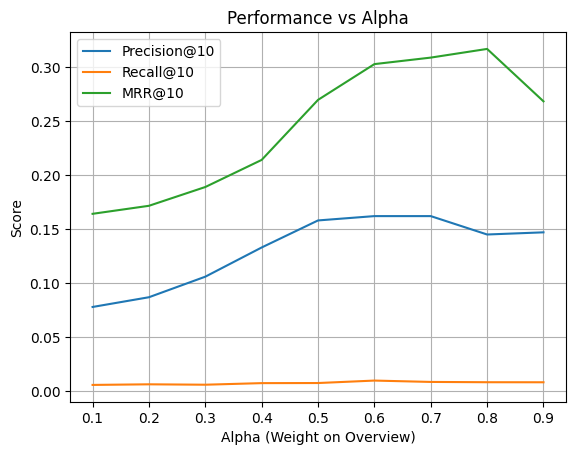

In [18]:
# Load embeddings and model_df (if necessary)
model_df = pd.read_csv("model_df.csv")
overview_embeddings = np.load('./embeddings/overview_embeddings.npy')
synthetic_embeddings = np.load('./embeddings/synthetic_embeddings.npy')

# Define the range of alpha values to test (0.1 to 0.9)
alphas = [0.1 * i for i in range(1, 10)]  # 0.1 to 0.9

# Store evaluation results for each alpha
results = []

# Loop over each alpha value and evaluate performance
for alpha in alphas:
    print(f"\nEvaluating for alpha = {alpha:.1f} (overview weight)...")

    # Weighted combination of embeddings
    combined = alpha * overview_embeddings + (1 - alpha) * synthetic_embeddings

    # Evaluate on 100 randomly chosen titles at top-10
    precision, recall, mrr = evaluate_multiple_queries(model_df, combined, num_samples=100, k=10)
    results.append((alpha, precision, recall, mrr))

# Display Results
print("\nAlpha Tuning Results:")
for alpha, precision, recall, mrr in results:
    print(f"Alpha {alpha:.1f} | Precision@10: {precision:.4f} | Recall@10: {recall:.4f} | MRR@10: {mrr:.4f}")

# Plot
alphas_np = [r[0] for r in results]
precisions = [r[1] for r in results]
recalls = [r[2] for r in results]
mrrs = [r[3] for r in results]

plt.plot(alphas_np, precisions, label='Precision@10')
plt.plot(alphas_np, recalls, label='Recall@10')
plt.plot(alphas_np, mrrs, label='MRR@10')
plt.xlabel("Alpha (Weight on Overview)")
plt.ylabel("Score")
plt.title("Performance vs Alpha")
plt.legend()
plt.grid(True)
plt.show()

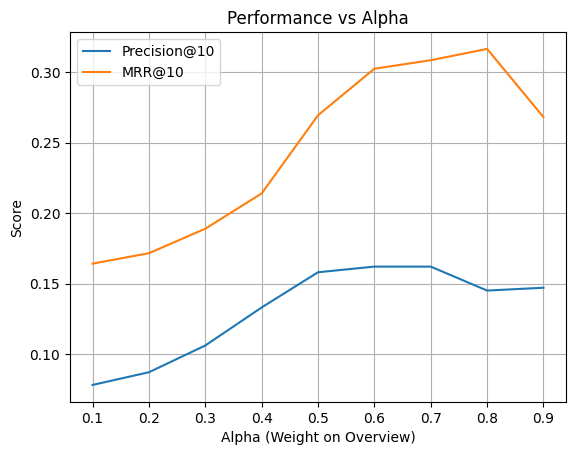

In [19]:
# Plot
alphas_np = [r[0] for r in results]
precisions = [r[1] for r in results]
mrrs = [r[3] for r in results]

plt.plot(alphas_np, precisions, label='Precision@10')

plt.plot(alphas_np, mrrs, label='MRR@10')
plt.xlabel("Alpha (Weight on Overview)")
plt.ylabel("Score")
plt.title("Performance vs Alpha")
plt.legend()
plt.grid(True)
plt.show()